# Is managerial tone of voice influenced by macroeconomic circumstances?

#### Jerome Crijns, Stefan Romeijn 

# Introduction

In [151]:
pip install pandoc

pip install nbconvert

jupyter nbconvert --to html Crijns, Romeijn.ipynb

SyntaxError: invalid syntax (<ipython-input-151-0f6d4c2980af>, line 1)

In our assignment, we zoom in on MD&As (Management Discussion & Analysis) - the part of a public company's annual report or 'Form 10-K' in which the management addresses current issues and future challenges. We are interested in linking these reports to macroeconomic circumstances (proxied by GDP) in the fiscal year prior to the time of writing. Hence, the question is whether the tone of language mentioned within these reports is (either negatively or positively) related to economic circumstances. The rationale here is that writing on future events may either signal trust and confidence, or might signal concerns towards the stakeholders.

Thus, we hope to shed more light on this relationship. We will not investigate whether this relationship is negative or positive, but focus first and foremost on whether there exists a (statistically significant) linkage. Here, the GDP developments are the independent variable while the tone of language in the MD&As is the dependent variable. In order to retrieve the 10-K files relevant to our approach, we use the electronic filing system created by the SEC called EDGAR.
As for macroeconomic circumstances, we consider GDP developments in the United States (https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=US). We focus on the period of 1994-2017, as the EDGAR database became available in 1994.

Following previous literature (Muslu et al. 2011, Muslu et al. 2015) we describe these future-oriented words of interest as: “future”, “will”, “next month”, “next quarter”, “next year”, “next fiscal”, “next period”, “upcoming month”, “coming month”, “coming quarter”, “coming year”, “coming fiscal”, “subsequent month”, “subsequent quarter”, “subsequent year”, “subsequent fiscal”,  “following month”, “following quarter”, “following year” and “following fiscal”. Although of course not conclusive, these words may serve as a proxy for future orientation of MD&A.

We find this research topic particularly interesting for this Python assignment, as it is generally difficult to automize search commands in a purely qualitative environment such as a firm's report. In the steps described below, we hope to clearly describe firstly this qualitative approach and secondly, to link it to the GDP developments in retrieving a linkage between both. Our key assumption here that if indeed we find a statistically significant relationship, this is immediately causal as well. We regard this as possible because GDP enables as-good-as-random selection; i.e. a firm has no influence on macroeconomic developments whatsoever, let alone the tone of voice applied by a manager in his MD&A.

# Approach

In the file below, we have made splits within the file to make clear we are moving towards a new (type of) action. We provide a
brief decription accompanying each of these new actions. 

Please note that we have two parts in this Python script: one in which we describe the steps in order to gather our data, and one in which we create insights based on this data gathered. This first part requires three additional plug-ins: requests, BeautifulSoup4, and docopt. We provide the command lines with which these plug-ins can be downloaded below. 

Also, before using the mdatool and 10ktool to search for the future-oriented keywords, you should download the database (EdgarSearch.py download). It will download years 1994 to 2017 by default. As this is an enormous bulk of data, please note that doing so is also accompanied with - in our experience - some two weeks of processing. Because of this huge processing time, and the external libraries mentioned before, although we provide the script for this step under "a) Gathering the data", the Jupyter Notebook does not in fact download the entire bulk of 10-K filings and MD&As. This is because Jupyter Notebook is the shell, while a program such as Atom in fact downloads the files to a directory on your pc (one could of course check this by trying the script in Atom).

The script used to retrieve this data is based on another script found on Jupyter Notebook (https://github.com/iammrhelo/edgar-10k-mda/blob/master/edgar.py). Note that multiple lines of code are broken ( EXAMPLE XXX),  and not mentioning anything about the wordcount, which is the heart of our research. It has only provided us with input to retrieve the 10-K filings and MD&As.

After the part of data gathering, we move on to the more interesting part: creating insights based on the MD&As. Finally, to answer our research question, we relate these insights to US data on GDP developments in the period of 1994 to 2017.

### a) Gathering the data

These are the lines of code installing the external libraries, referred to in Approach.

import sys
!{sys.executable} -m pip install docopt

!{sys.executable} -m pip install requests

!{sys.executable} -m pip install BeautifulSoup4

!{sys.executable} -m pip install lxml

To begin, we download the files relevant to our research and parse the exact aspects which we need. As we used from Stefan's computer, the directory refers to him.
 
First command: download the index and download 10-K filings.
    C:\Users\Stefan Romeijn\Desktop\Python opdracht\EdgarSearch\EdgarSearch>Python EdgarSearch.py download
            
Second command: parse MD&A from 10-K filings. Basically, this command separates item 7 - which is the MD&A - from the 10-K filing. It counts the words indicated in the command line below, which are described in line with Muslu et al. (2011, 2015). The output is structured in a CSV file, which was import as a pandas list.
    C:\Users\Stefan Romeijn\Desktop\Python opdracht\EdgarSearch\EdgarSearch>Python EdgarSearch.py mdatool --keywords=future,will,next_month,next_quarter,next_year,next_fiscal,next_period,upcoming_month,coming_month,coming_quarter,coming_year,coming_fiscal,
subsequent_month,subsequent_quarter,subsequent_year,subsequent_fiscal,following_month,following_quarter,following_year,following_fiscal

In [73]:
"""Edgar 10k MD&A Extractor
Usage:
    EdgarSearch.py download [options]
    EdgarSearch.py mdatool [options] --keywords=keyword1,keyword2,keyword_with_spaces
    EdgarSearch.py 10ktool [options] --keywords=keyword1,keyword2,keyword_with_spaces

"""

'Edgar 10k MD&A Extractor\nUsage:\n    EdgarSearch.py download [options]\n    EdgarSearch.py mdatool [options] --keywords=keyword1,keyword2,keyword_with_spaces\n    EdgarSearch.py 10ktool [options] --keywords=keyword1,keyword2,keyword_with_spaces\n\n'

In [65]:
import csv
import itertools
import os
import re
import time
import random

We download 'random' to the file for what mean seem not a very intuitive reason. Random, namely, chooses a variables between 0.5 and 2 seconds between each request-for-data to the online EDGAR database. The reason is that EDGAR, alike other online databases, is wary of receiving DDOS-attacks and the proxy for EDGAR to decide upon a DDOS-attack is the frequency of requests within some short amount of time.

By running our code, we spit out over thousands of requests towards the EDGAR database in order to retrieve the MD&As for our relevant quarters (1994-2017). Hence, in order not to become victim of this DDOS suspicion, we need to circumvent it by randomzing the time between our requests.

In [66]:
import unicodedata
from collections import namedtuple
from glob import glob

import requests
from bs4 import BeautifulSoup
from docopt import docopt

The relevant URLs for downloading the files are:

In [67]:
SEC_GOV_URL = 'https://www.sec.gov/Archives'
FORM_INDEX_URL = (SEC_GOV_URL+'/'+'edgar'+'/'+'full-index'+'/'+'{}'+'/'+'QTR{}'+'/'+'form.idx')
IndexRecord = namedtuple(
    "IndexRecord", ["form_type", "company_name", "cik", "date_filed", "filename",'filed_date'])

We now parse the row to records.

In [68]:
def parse_row_to_record(row, fields_begin, year):
    record = []
    for begin, end in zip(fields_begin[:], fields_begin[1:] + [len(row)]):
        field = row[begin:end].rstrip()
        field = field.strip('\"')
        record.append(field)
    record.append('0')
    faod = record[3]
    record[5] = faod
    record[3] = year
    return record

We then download and extract the index files. 

We noticed that the quarter 4 of 2011 and quarter 3 of 2017 were not downloaded by the script, meaning we had to download data from those quarters apart from the rest.

In [69]:
def download_and_extract_index(opt):
    index_dir = opt["--index-dir"]
    if not os.path.exists(index_dir):
        os.makedirs(index_dir)

    year_start = int(opt["--year-start"])
    year_end = int(opt["--year-end"])
    
    for year, qtr in itertools.product(range(year_start, year_end+1), range(1, 5)):

        form_idx = "{}_qtr{}.index".format(year, qtr)
        form_idx_path = os.path.join(index_dir, form_idx)
        index_url = FORM_INDEX_URL.format(year, qtr)
        file_error = 0
        if not os.path.exists(form_idx_path):
            if year == 2011 and qtr == 4 :
                print('[*] 2011 quarter 4 backup not found, please move it from /Edgar/Index/Backup to /Edgar/Index/')
                file_error += 1
            elif year == 2017 and qtr == 3 :
                print('[*] 2017 quarter 3 backup not found, please move it from /Edgar/Index/Backup to /Edgar/Index/!')
                file_error += 1
            if file_error == 1:
                exit(0)
            if file_error == 2:
                print("Both included files not found, please move them from /Edgar/Index/Backup to /Edgar/Index/")
                exit(0)
            try:
                print("[*] Downloading file : {}".format(index_url))
                res = requests.get(index_url,timeout=10)
                if res.status_code != requests.codes.OK:
                    raise Exception
                with open(form_idx_path, 'w') as fout:
                    txt = res.text
                    fout.write(txt)
                    
            except(ConnectionError,requests.RequestException) as e:
                print('[!] Download failed for - {} Connection error!'.format(index_url) + str(e))
            except:
                print("[!] Download failed - {}".format(index_url))
        else:
        # The server won't send two specific files, they are included with the script for completion
            if year == 2011 and qtr == 4 :
                print('[*] Found 2011 quarter 4 backup!')
            elif year == 2017 and qtr == 3 :
                print('[*] Foud 2017 quarter 3 backup!')
            else :
                print('[*] Already got file {} Not downloading again'.format(form_idx_path))
                
    print("[i] Finished downloading the index files")

    records = []
    for index_file in sorted(glob(os.path.join(index_dir, "*.index"))):
        print("[i] Extracting 10K filings from {}".format(index_file))

        with open(index_file, 'r',encoding = "ISO-8859-1") as fin:
            arrived = False
            spacing = opt["--index-dir"]
            start = 1 + len(spacing)
            CYEAR = index_file[start:start + 4]
            for row in fin.readlines():
                if row.startswith("Form Type"):
                    fields_begin = [row.find("Form Type"),
                                    row.find("Company Name"),
                                    row.find('CIK'),
                                    row.find('Date Filed'),
                                    row.find("File Name")]

                elif row.startswith("10-K "):
                    arrived = True
                    rec = parse_row_to_record(row, fields_begin, CYEAR)
                    records.append(IndexRecord(*rec))

                elif arrived == True:
                    break
                    
    index_10k_path = opt["--index-10k-path"]
    with open(index_10k_path, 'w') as fout:
        writer = csv.writer(fout, delimiter=',',
                            quotechar='\"', quoting=csv.QUOTE_ALL)
        for rec in records:
            writer.writerow(tuple(rec))

We then download the 10-K filings.

In [70]:
def download_10k(opt):
    print("[i] Downloading the 10K filings")
    index_10k_path = opt["--index-10k-path"]
    if not (os.path.exists(index_10k_path)):
        print("[i] File {} doesn't exist, something went wrong!".format(index_10k_path))
    form10k_dir = opt["--10k-dir"]
    if not os.path.exists(form10k_dir):
        os.makedirs(form10k_dir)
    count = 0
    with open(index_10k_path, 'r') as fin:
        reader = csv.reader(
            fin, delimiter=',')
        for row in reader:
            if(row and row != None):
                CIK = row[2]
                YEAR = row[3]
                FILEDASOFDATE = row[5]
                COMPANY_NAME = row[1].replace(" ", '').replace("/",'')
                _, _, _, _, filename, _ = row
                fname = COMPANY_NAME + "_" + CIK +"_"+ YEAR + "_"+FILEDASOFDATE+".txt"
                text_path = os.path.join(form10k_dir,fname)
                if not os.path.exists(text_path):
                    url = os.path.join(SEC_GOV_URL, filename).replace("\\", "/")
                    try:
                        res = requests.get(url,timeout=10)
                        soup = BeautifulSoup(res.content, 'lxml')
                        text = soup.get_text("\n")
                        text2 = re.sub('[^a-zA-Z0-9.,:\n\t\b]',' ',text)
                        with open(text_path, 'w') as fout:
                            fout.write(text2)
                        #Sleeping between 0.5 and 2 seconds to prevent being detected as a bot by the server.
                        anti_bot = random.uniform(0.5, 2)
                        time.sleep(anti_bot)

                    except Exception as e:
                        print("[!] Couldn't download 10K file - {} - {}".format(url, e))
                else:
                    pass

As we're interested in the specific MD&A parts within the larger 10-K filings, we specifically fetch these.

In [71]:
def extract_mda(opt, keyword_list):
    print("[i] Extracting MDA's")
    form10k_dir = opt["--10k-dir"]
    assert os.path.exists(form10k_dir)
    mda_dir = opt["--mda-dir"]
    if not os.path.exists(mda_dir):
        os.makedirs(mda_dir)
    records = []
    records.append(['NAME','CIK','YEAR', 'FILEDASOFDATE','TOTALWORDS'])
    for keyword in keyword_list:
        records[0].append(keyword.upper())
    print("[i] CSV columns :" + str(records))
    for form10k_file in sorted(glob(os.path.join(form10k_dir, "*.txt"))):
        path_info = form10k_file.split("_")
        YEAR = path_info[2]
        NAME = path_info[0][len(form10k_dir) +1:]
        CIK = path_info[1]
        filedasofdate = path_info[3][:-4]
        row = [NAME,CIK,YEAR,'0','0']
        # Read form 10k
        with open(form10k_file, 'r') as fin:
            text = fin.read()
        # Normalize
        text = normalize_text(text)
        
        # Find the MDA section
        mda, end = parse_mda(text)
        # Parse for a second time if needed
        if mda and len(mda.encode('utf-8')) < 1000:
            mda, _ = parse_mda(text, start=end)

In the final step of this data gathering, we focus on the keywords supplied in the Introduction - namely, those which include future-oriented language. We then perform a word count to find exactly how much future-oriented language was used in the MD&A per firm.

In [156]:
        if mda:
            #If the MDA was found, we'll search for the supplied keywords and the MDA will be extracted to a new file
            filename = os.path.basename(form10k_file)
            name, ext = os.path.splitext(filename)
            mda_name = (name + ".mda")
            mda_path = os.path.join(opt["--mda-dir"], mda_name)
            if not os.path.exists(mda_path):
                with open(mda_path, 'w') as fout:
                    fout.write(mda)
            wordcount = []
            num_keywords = 0
            for keyword in keyword_list:
                num_keywords += 1
                if " " in keyword:
                    wordcount.append(count_words_sentence(mda.lower(), keyword))
                else:
                    wordcount.append(count_words(mda.lower(), keyword))
            totalwords = mda.split()
            totalcount = 0
            for word in totalwords:
                totalcount += 1
            row[4] = totalcount
            row[3] = filedasofdate
            for i in range(0,num_keywords):
                row.append(wordcount[i])
            records.append(row)
    print("[!] Extracted all MDA's!")
    data_path = opt["--mda-keyword-path"]
    with open(data_path, 'w') as fout:
        writer = csv.writer(fout, delimiter=',', quotechar='\"', quoting=csv.QUOTE_ALL)
        for rec in records:
            writer.writerow(tuple(rec))
    print("[*] All done! Keyword files can be found here: " + data_path)

def normalize_text(text):
    #normalizing the text
    text = unicodedata.normalize("NFKD", text)  # Normalize
    text = '\n'.join(
        text.splitlines())  # Let python take care of unicode break lines

    # Convert to uppercase
    text = text.upper()  # Convert to upper

    # Removing linebreaks and whitespaces
    text = re.sub(r'[ ]+\n', '\n', text)
    text = re.sub(r'\n[ ]+', '\n', text)
    text = re.sub(r'\n+', '\n', text)

    # To find MDA section, reformat item headers
    text = text.replace('\n.\n', '.\n')

    text = text.replace('\nI\nTEM', '\nITEM')
    text = text.replace('\nITEM\n', '\nITEM ')
    text = text.replace('\nITEM  ', '\nITEM ')

    text = text.replace(':\n', '.\n')

    # Replace symbols
    text = text.replace('$\n', '$')
    text = text.replace('\n%', '%')

    # Reformat
    text = text.replace('\n', '\n\n')

    return text

def count_words(text, keyword):
    #Counts keywords in text and returns count
    count = 0
    text = text.split()
    for word in text:
        word.lower()
        if word == keyword:
            count += 1
    return count

def count_words_sentence(text, keyword):
    #Counts keywords with spaces and returns the count
    count = 0
    text = text.replace("\n", ".")
    text = text.split('.')
    for line in text:
        if keyword in line:
            count += 1
    return count


def parse_mda(text, start=0):
    #Parses the MDA section
    mda = ""
    end = 0

    item7_starts = ['\nITEM 7.', '\nITEM 7 –', '\nITEM 7:', '\nITEM 7 ', '\nITEM 7\n']
    item7_ends = ['\nITEM 7A']
    if start != 0:
        item7_ends.append('\nITEM 7')
    item8_starts = ['\nITEM 8']
    text = text[start:]

    # Get start
    for item7 in item7_starts:
        start = text.find(item7)
        if start != -1:
            break

    if start != -1:
        for item7A in item7_ends:
            end = text.find(item7A, start + 1)
            if end != -1:
                break

        if end == -1:
            for item8 in item8_starts:
                end = text.find(item8, start + 1)
                if end != -1:
                    break

        if end > start:
            mda = text[start:end].strip()
        else:
            end = 0

    return mda, end


if __name__ == "__main__":
    #Main function
    opt = docopt(__doc__)
    print('[*] Welcome mister Boone! ')
    keyword_arguments = opt["--keywords"].lower()
    keywords = keyword_arguments.replace("_"," ").split(',')
    keyword_list = []
    for keyword in keywords:
        keyword_list.append(keyword)
    if opt["download"]:
        #Download all files
        print("[i] Downloading all files - this might take some time.")
        download_and_extract_index(opt)
        download_10k(opt)
        print("[*] Downloads complete!")
    elif opt["mdatool"]:
        #Extract mda and search for keywords
        extract_mda(opt, keyword_list)
    elif opt["10ktool"]:
        #Search for keywords in the entire 10K filings
        wordcount_10k(opt, keyword_list)
    print("[*] Thank you for checking the 10-K filings. We hope you have become inspired.")


IndentationError: expected an indented block (<ipython-input-156-4dd818b530cf>, line 30)

### b) Creating insights

After some thorough data scraping, we now enter the fun part: creating insights! We use the pandas framework to work with our data.

In [93]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

We then import lists (as CSV files). The keyword list is directly downloaded from the previous script. The GDP file is downloaded from https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=US.

In [97]:
keywords_df = pd.read_csv("C:/Users/jerom/OneDrive/Documenten/Python/CSVreader/Keywords.csv")
gdp_df = pd.read_csv("C:/Users/jerom/OneDrive/Documenten/Python/CSVreader/gdp.csv")

In total, we obtain a whopping 146,292 observations. However, we find there to be 1,442 duplicate observations in the keywords dataframe, meaning we drop those duplicate observations. The dataset now contains 144,850 observations.

In [98]:
duplicates_df = keywords_df[keywords_df.duplicated(['CIK', 'YEAR'])]
keywords_df.drop_duplicates(['CIK', 'YEAR'], keep = 'first', inplace=True)

Totals per column are calculated in order to get a total nominal amount of future-oriented words, which is then divided by the total lenght of the MD&A to construct a relative variable. 

In [99]:
keywords_df.loc[:,'Total'] = keywords_df.iloc[:,5:25].sum(axis=1)
keywords_df.loc[:,'Percfuture'] = keywords_df['Total']/keywords_df['TOTALWORDS'] *100
print(np.mean(keywords_df['Percfuture']))

0.38878360326870604


dAta is sorted based on a Central Identifier Key (CIK) and year. We lag the newly created variable percfuture by one year because the MD&A is always being published a few months after the fiscal year ended.

In [100]:
keywords_df.sort_values(["CIK",'YEAR'])
keywords_df.loc[:,'Percfuturelag'] = keywords_df.groupby('CIK')['Percfuture'].shift(1)
print(np.mean(keywords_df['Percfuturelag']))

0.38260306483172085


The dataframe is merged on a many-to-one basis with the GDP dataframe.

In [101]:
merged_df = pd.merge(keywords_df, gdp_df, on ='YEAR')
merged_df["gdpgrowth"] = merged_df["gdpgrowth"]*100

We now obtain a visual analysis and some descriptive statistics. The plot hows the average percentage of future orienation of MD&A over the years.

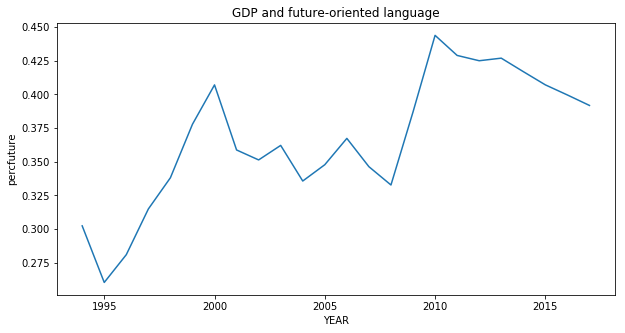

In [149]:
avg_percfuture = merged_df.groupby('YEAR')['Percfuturelag'].agg('mean')
avg_percfuture.plot(figsize=(10,5))
plt.title('GDP and future-oriented language')
plt.ylabel('percfuture')
plt.show()

In order to prevent a year-related bias, we also plot the GDP developments independent of future-oriented language. The below graph clearly shows there is something going on: the major economic rise pre- and post-crises, first because of the Dotcom bubble and second because of the sub-prime mortgage crisis.

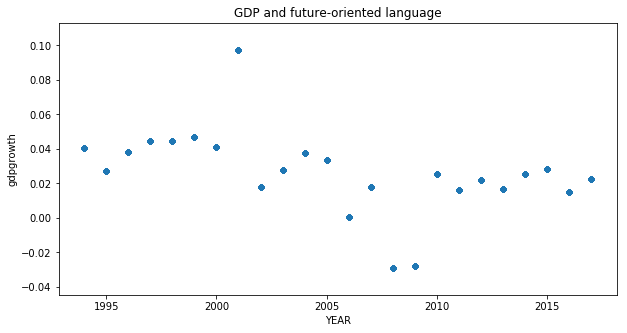

In [150]:
merged_df.plot(figsize=(10,5), x='YEAR', y='gdpgrowth', kind='scatter')
plt.title('GDP and future-oriented language')
plt.show()

Finally, we obtain a table of descriptive statistics. It shows us that the shortest MD&A file consists of only 4 words, while the longest one embodies 295987 words - quite a difference. The average MD&A file consists of 6249 words. As for the variable percfuturelag: in one report, 3.93% of the entire report consists of future-oriented language which is the maximum. There average report is .34% of future-oriented language, meaning there is one future-oriented term per 300 words.

In the 'Total' section, we find that the average report has 28 future-oriented terms in it, and the maximum 581.

In [131]:
Descriptives_df = merged_df[["TOTALWORDS","Percfuturelag","gdpgrowth","Total"]]
print(Descriptives_df.describe(include='all'))

          TOTALWORDS  Percfuturelag      gdpgrowth          Total
count  144850.000000  121527.000000  144850.000000  144850.000000
mean     7886.431253       0.382603       0.023043      28.278398
std      7444.316228       0.262373       0.024721      27.160645
min         4.000000       0.000000      -0.029162       0.000000
25%      2835.000000       0.230080       0.016015      11.000000
50%      6249.000000       0.341297       0.025319      22.000000
75%     10853.750000       0.479335       0.037857      38.000000
max    295987.000000       3.932584       0.097598     581.000000


We run a univariate analysis to estimate the causal effect of macro-economic conditions on management tone of voice. A causal interpretation is warranted, as we deal with (as-good-as) random variation into GDP developments. In order to estimate a constant for OLS regression, the value of 1 is added to the merged dataframe. Furthermore, year dummies are added.

In [114]:
merged_df.loc[:,'Constant']=1
dummies_df = pd.get_dummies(merged_df, columns= ['YEAR'])
mergedplusdummies_df = pd.merge(merged_df, dummies_df)

To avoid a dummy trap, we ommit the first year. Hence, the dummy coefficient output of univariate analysis is estimated relative to the omitted year 1994.

In [158]:
mergedplusdummies_df.drop(columns = ['YEAR_1994'])
data_df=mergedplusdummies_df.loc[:,['Percfuturelag','gdpgrowth','Constant','YEAR_1995','YEAR_1996','YEAR_1997','YEAR_1998','YEAR_1999','YEAR_2000','YEAR_2001','YEAR_2002','YEAR_2003','YEAR_2004','YEAR_2005','YEAR_2006','YEAR_2007','YEAR_2008','YEAR_2009','YEAR_2010','YEAR_2011','YEAR_2012','YEAR_2013','YEAR_2014','YEAR_2015','YEAR_2016','CIK']].dropna(how='any')
reg1= sm.OLS(endog=data_df['Percfuturelag'], exog=data_df[['gdpgrowth','Constant','YEAR_1995','YEAR_1996','YEAR_1997','YEAR_1998','YEAR_1999','YEAR_2000','YEAR_2001','YEAR_2002','YEAR_2003','YEAR_2004','YEAR_2005','YEAR_2006','YEAR_2007','YEAR_2008','YEAR_2009','YEAR_2010','YEAR_2011','YEAR_2012','YEAR_2013','YEAR_2014','YEAR_2015','YEAR_2016']],missing='drop')
results = reg1.fit(cov_type = 'cluster', cov_kwds= {'groups':data_df['CIK']})
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Percfuturelag   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     79.66
Date:                Sat, 19 Jan 2019   Prob (F-statistic):               0.00
Time:                        17:59:43   Log-Likelihood:                -8451.8
No. Observations:              121527   AIC:                         1.695e+04
Df Residuals:                  121503   BIC:                         1.718e+04
Df Model:                          23                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gdpgrowth     -5.0665      0.868     -5.834      0.0

[1] We clustered standard errors by CIK to control for serial correlation of future-oriented words in firms' year-to-year MD&A, which would result in an underestimation of these standard errors. 
[2] Although we receive a warning for multicollinearity, this is no issue in this case. We use a univariate analysis complemented by some year dummies, meaning there is by definition no risk of correlation. There are no other independent variables which can be correlated either - hence, there is no risk of multicollinearity.

# Limitations

We distinguish between two key limitations within this small research. 

First, the explanatory power of the regression is likely to be rather small. We obtain a fairly low R-squared, which is not strange as use only one variable to indice a relationship. Effectively, this means that our dependent variable explains only to a very limited extent the variability of the real data. Why shouldn't this figure be larger? Because although the two may correlate, it could never be the case that Firm X is so strongly dependent on the GDP developments in using future-oriented language, and vice versa.

This brings us to the second aspect: the direction of the relationship is unknown. Although we happen to find a significant effect between GDP developments and future-oriented language, our analysis is not able to tell the direction of the relationship: which is the dependent variable, which is the independent variable? In the introduction, we assumed that if there is a relationship, it would be from GDP developments towards the use of future-oriented language. We make this assumption because of two key reasons. First, the economy as a whole is much more likely to have effect effect on a single firm than the other way around. Second, and even more obvious, we interpret language use in MD&As following a fiscal year, rather than preceding it. In other words, GDP developments in t are the first mover; MD&As reports (and any) future-oriented language thereof, is the second mover.

# Conclusion

To conclude, we have indeed found a statistically significant effect between GDP developments and future-oriented language used in MD&As. Our recommendation for future research derives from the points which we would like more information on. 

Primarily, this concerns the strength of the effect between GDP developments and future-oriented language in MD&As. Is the latter indeed a solid predictor for the former, or is there a (number of) variable(s) with more predictive power? More precisely, would we obtain a stronger relationship if we consider the influence of firm-specific aspects on future-oriented language - are managers trying to deflect negative results in 2017 by talking about the future in their 2018 MD&A? Related to this point, what if we focus on the exact nature of the future-oriented language, namely of it being positive or negative? Are managers more likely to paint a negative prospect following a year of disappointed (macro- or firm-)developments, or will they seek the positive tone of voice?

These factors are food for thought in future research.